In [1]:
import logging

import japanize_matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import polars as pl
import rootutils
import seaborn as sns

sns.set_style("whitegrid")
logging.basicConfig(level=logging.INFO)

ROOT = rootutils.setup_root(".", pythonpath=True, cwd=True)

DATA_DIR = ROOT / "data"
INPUT_DIR = DATA_DIR / "atmacup19_dataset"
OUTPUT_DIR = DATA_DIR / "output"
CACHE_DIR = DATA_DIR / "cache"

for d in [DATA_DIR, INPUT_DIR, OUTPUT_DIR, CACHE_DIR]:
    d.mkdir(exist_ok=True, parents=True)

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_tbl_cols(50)
pl.Config.set_tbl_rows(50)


polars.config.Config

### load data


In [2]:
ec_log_df = pl.read_csv(INPUT_DIR / "ec_log.csv", infer_schema_length=200000)
jan_df = pl.read_csv(INPUT_DIR / "jan.csv")
test_session_df = pl.read_csv(INPUT_DIR / "test_session.csv")
train_session_df = pl.read_csv(INPUT_DIR / "train_session.csv")
train_log_df = pl.read_csv(INPUT_DIR / "train_log.csv")

train_session_df = train_session_df.with_columns(pl.col("売上日").cast(pl.Date)).with_columns(
    pl.datetime(
        pl.col("売上日").dt.year(), pl.col("売上日").dt.month(), pl.col("売上日").dt.day(), pl.col("時刻")
    ).alias("session_datetime")
)

### build graph


In [3]:
def create_noleak_graph_df(
    train_session_df: pl.DataFrame,
    train_log_df: pl.DataFrame,
    jan_df: pl.DataFrame,
    cat_type: str = "部門",
) -> pl.DataFrame:
    # jan を含む log を作成
    log_df = (
        train_session_df.select(["session_id", "session_datetime", "顧客CD"])
        .join(train_log_df.filter(pl.col("売上数量") > 0).select(["session_id", "JAN"]), on="session_id", how="left")
        .join(jan_df, on="JAN", how="left")
        .select(["session_id", "session_datetime", "顧客CD", cat_type])
        .unique()
        .sort(["顧客CD", "session_datetime"])
    ).lazy()

    # leak しない session の base_df を作成: session_id 以前の session_id を parent_session_id として持つ
    # 特徴量として使用する場合を想定
    base_df = (
        log_df.select(["session_id", "session_datetime", "顧客CD"])
        .join(log_df.select(["session_id", "session_datetime"]), how="cross")
        .filter(
            (pl.col("session_datetime") >= pl.col("session_datetime_right"))
            & (pl.col("session_id") != pl.col("session_id_right"))
        )
        .unique()
        .select(
            pl.col("session_id"),
            pl.col("session_datetime"),
            pl.col("顧客CD"),
            pl.col("session_id_right").alias("parent_session_id"),
        )
    )

    # cat_type ごとの edge を作成
    session_cat_duration_df = (
        log_df.join(log_df, how="cross")
        .filter(
            (pl.col("session_datetime") <= pl.col("session_datetime_right"))
            & (pl.col("session_id") != pl.col("session_id_right"))
            & (pl.col("顧客CD") == pl.col("顧客CD_right"))
        )
        .select(
            pl.col("session_id").alias("parent_session_id"),
            pl.col("session_datetime").alias("parent_session_datetime"),
            pl.col("session_id_right").alias("child_session_id"),
            pl.col("session_datetime_right").alias("child_session_datetime"),
            pl.col(cat_type).alias(f"src_{cat_type}"),
            pl.col(f"{cat_type}_right").alias(f"tgt_{cat_type}"),
            ((pl.col("session_datetime_right") - pl.col("session_datetime")) / pl.duration(days=1)).alias("days_diff"),
        )
    )

    result_df = base_df.join(session_cat_duration_df, on="parent_session_id", how="left")
    return result_df.collect()


graph_df = create_noleak_graph_df(
    train_session_df=train_session_df.filter(
        pl.col("顧客CD") == "463dee52b873b05276bcd25d9fe76ad2977312271d9d8fe987be324abb93d809"
    ),
    train_log_df=train_log_df,
    jan_df=jan_df,
)
graph_df.head()

session_id,session_datetime,顧客CD,parent_session_id,parent_session_datetime,child_session_id,child_session_datetime,src_部門,tgt_部門,days_diff
str,datetime[μs],str,str,datetime[μs],str,datetime[μs],str,str,f64
"""DKoFQfsqhrtEZFZkWoaScW""",2024-10-02 18:00:00,"""463dee52b873b05276bcd25d9fe76ad2977312271d9d8fe987be324abb93d809""","""KhgSshh5N3gBTCVt7ddEK6""",2024-09-17 18:00:00,"""9CJaKwZyTwFZ6f3UbTerps""",2024-09-26 23:00:00,"""日配飲料""","""日配飲料""",9.208333
"""DKoFQfsqhrtEZFZkWoaScW""",2024-10-02 18:00:00,"""463dee52b873b05276bcd25d9fe76ad2977312271d9d8fe987be324abb93d809""","""KhgSshh5N3gBTCVt7ddEK6""",2024-09-17 18:00:00,"""9CJaKwZyTwFZ6f3UbTerps""",2024-09-26 23:00:00,"""飲料""","""日配飲料""",9.208333
"""DKoFQfsqhrtEZFZkWoaScW""",2024-10-02 18:00:00,"""463dee52b873b05276bcd25d9fe76ad2977312271d9d8fe987be324abb93d809""","""KhgSshh5N3gBTCVt7ddEK6""",2024-09-17 18:00:00,"""9CJaKwZyTwFZ6f3UbTerps""",2024-09-26 23:00:00,"""スナック・キャンディー""","""日配飲料""",9.208333
"""DKoFQfsqhrtEZFZkWoaScW""",2024-10-02 18:00:00,"""463dee52b873b05276bcd25d9fe76ad2977312271d9d8fe987be324abb93d809""","""KhgSshh5N3gBTCVt7ddEK6""",2024-09-17 18:00:00,"""9CJaKwZyTwFZ6f3UbTerps""",2024-09-26 23:00:00,"""ビール系""","""日配飲料""",9.208333
"""DKoFQfsqhrtEZFZkWoaScW""",2024-10-02 18:00:00,"""463dee52b873b05276bcd25d9fe76ad2977312271d9d8fe987be324abb93d809""","""KhgSshh5N3gBTCVt7ddEK6""",2024-09-17 18:00:00,"""9CJaKwZyTwFZ6f3UbTerps""",2024-09-26 23:00:00,"""塩干""","""日配飲料""",9.208333


(190, 4)


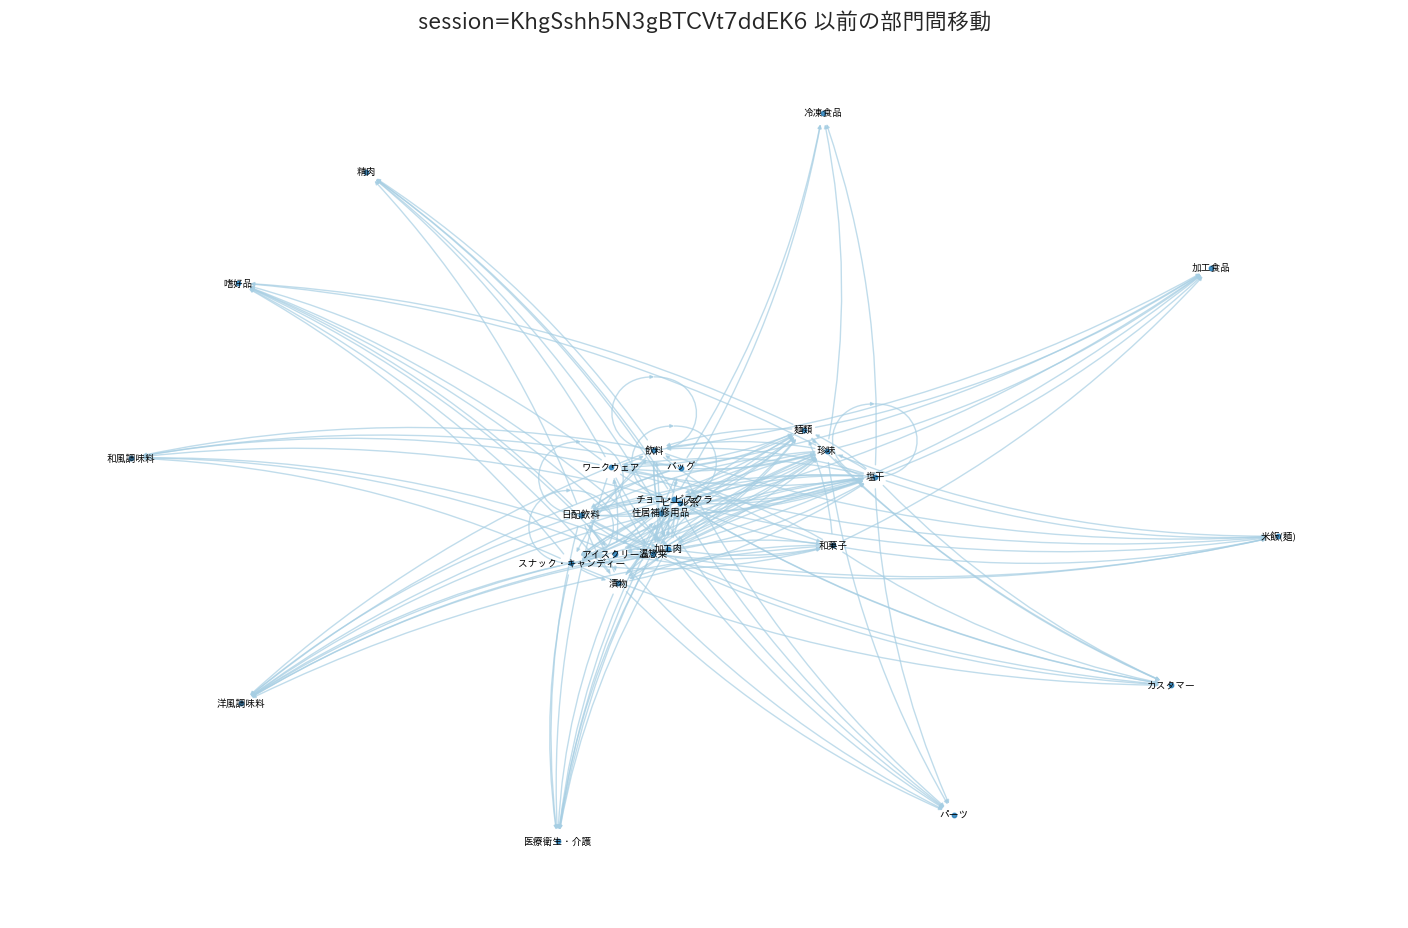

In [ ]:
japanize_matplotlib.japanize()


def visualize_session_graph(
    graph_df: pl.DataFrame,
    session_id: str,
    src_node_col: str,
    tgt_node_col: str,
    edge_weight_col: str,
) -> plt:
    session_data = (
        graph_df.filter(pl.col("session_id") == session_id)
        .group_by([src_node_col, tgt_node_col])
        .agg(pl.mean(edge_weight_col).alias("avg_days"), pl.len().alias("count"))
    ).sample(fraction=0.5, seed=42)  # sampling
    print(session_data.shape)
    assert len(session_data) > 0

    # グラフの作成
    G = nx.DiGraph()
    for row in session_data.iter_rows(named=True):
        src = row[src_node_col]
        tgt = row[tgt_node_col]
        days = row["avg_days"]
        count = row["count"]

        G.add_edge(src, tgt, weight=days, count=count)

    fig, ax = plt.subplots(figsize=(14, 10))

    pos = nx.spring_layout(G, k=0.2, iterations=100, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color="#1f78b4", alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color="#a6cee3", arrowsize=5, alpha=0.7, connectionstyle="arc3,rad=0.1")

    nx.draw_networkx_labels(G, pos, font_size=7, font_weight="bold", font_family="IPAexGothic")
    ax.set_title(f"session={session_id} 以前の部門間移動", fontsize=16)
    ax.axis("off")

    plt.tight_layout(pad=0.4, rect=[0, 0.03, 1, 0.95])

    return fig, ax


session_to_visualize = "KhgSshh5N3gBTCVt7ddEK6"
fig, ax = visualize_session_graph(
    graph_df=graph_df,
    session_id=session_to_visualize,
    src_node_col="src_部門",
    tgt_node_col="tgt_部門",
    edge_weight_col="days_diff",
)